In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Ниже приведены ф-ции, генерирующие различные ряды, содержащие выбросы. <br>Каждая ф-ция возвращает 2 массива: временной ряд и разметка к нему (какие из точек являются выбросами, а какие нет).

## Одиночные случайные выбросы

1. Генерируется ряд из нормального распределения
2. Случайные точки ряда умножаются на значения из промежутка [1.3, 2) или делятся на эту величину

In [2]:
def plot(y, out_target):
    
    colors = list(np.where(out_target, 'red', 'blue'))
    plt.figure(figsize=(20, 6))
    plt.scatter(range(len(y)), y, color=colors)
    

In [3]:
def gen_outliers(mean, scale=7, out_ratio=0.02, size=10000, seed=17):
    np.random.seed(seed)
    
    row = np.random.normal(loc=mean, scale=scale, size=size)
    
    out_target = np.random.choice([True, False], size, p=[out_ratio, 1-out_ratio])
    out_value = np.random.uniform(1.3, 2, size=size)
    out_sign = np.random.choice([True, False], size)
    row = np.where(out_target&out_sign, row*out_value, row)
    row = np.where(out_target&(~out_sign), row/out_value, row)
    return row, out_target

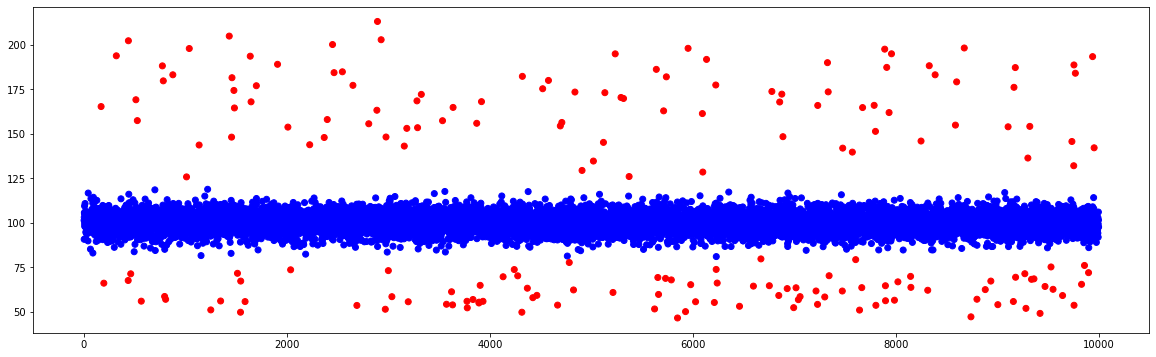

In [4]:
row, out_target = gen_outliers(100, 5)
plot(row, out_target)

## Случайные выбросы по несколько точек c разными значениями

1. Генерируется ряд из нормального распределения
2. Случайные подряд идущие "n_points" точек ряда умножаются на значения из промежутка [1.4, 3) или делятся на эту величину

In [5]:
def gen_outliers_in_row_random(mean, scale=5, n_points=5, out_ratio=0.015, size=10000, seed=17):
    np.random.seed(seed)
    
    row = np.random.normal(loc=mean, scale=scale, size=size)
    
    out_target = pd.Series(np.random.choice([True, False], size, p=[out_ratio, 1-out_ratio]))
    out_value = pd.Series(np.random.uniform(1.4, 3, size=size))
    out_sign = pd.Series(np.random.choice([True, False], size))
    
    out_target_df = pd.DataFrame()
    for i in range(n_points):
        out_target_df[f'{i}'] = out_target.shift(i)
        row = np.where(out_target.shift(i)&out_sign.shift(i), row*out_value.shift(i), row)
        row = np.where(out_target.shift(i)&(~out_sign.shift(i).fillna(True)), row/out_value.shift(i), row)
    out_target = out_target_df.any(axis=1)
    return row, out_target.values

In [6]:
row, out_target = gen_outliers_in_row_random(100, 5)

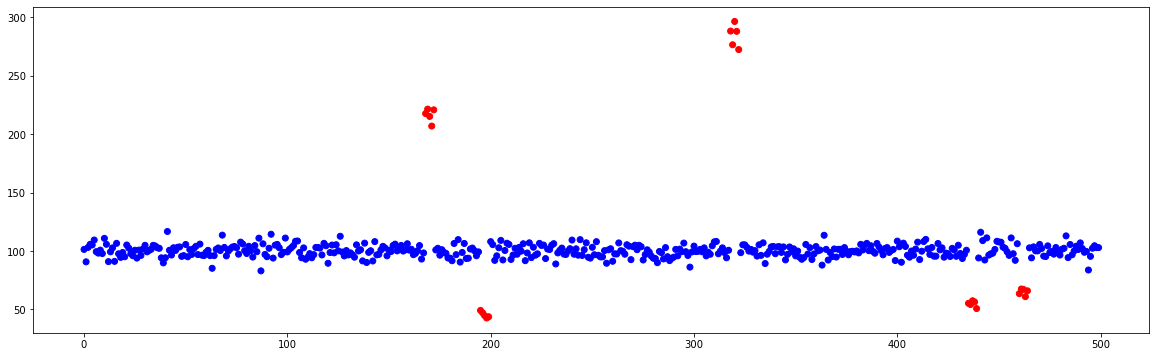

In [7]:
plot(row[0: 500], out_target[0: 500])

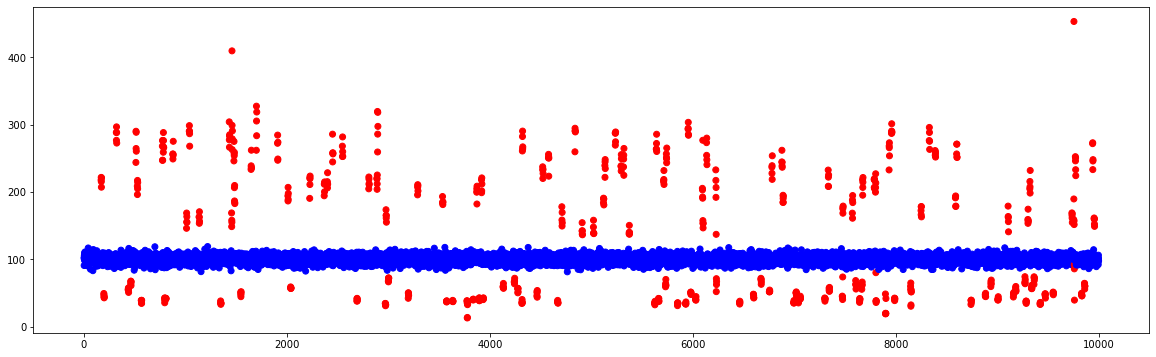

In [8]:
plot(row, out_target)

## Случайные выбросы по несколько точек c одинаковыми значениями

1. Генерируется ряд из нормального распределения
2. Случайные точки ряда умножаются на значения из промежутка [1.3, 2) или делятся на эту величину.
3. "n_points" точек, следующих за выбросом, имеют то же значение, что и сам выброс

In [9]:
def gen_outliers_in_row_equal(mean, scale=7, n_points=10, out_ratio=0.01, size=10000, seed=17):
    np.random.seed(seed)
    row = np.random.normal(loc=mean, scale=scale, size=size)
    
    out_target = np.random.choice([True, False], size, p=[out_ratio, 1-out_ratio])
    out_value = np.random.uniform(1.3, 2, size=size)
    out_sign = np.random.choice([True, False], size)
    row = np.where(out_target&out_sign, row*out_value, row)
    row = np.where(out_target&(~out_sign), row/out_value, row)
    row = pd.Series(row)
    out_target = pd.Series(out_target)
    
    for i in range(n_points+1):
        row = pd.Series(np.where(out_target.shift(i), row.shift(i), row))
    out_target = out_target.replace(False, np.nan).fillna(method='ffill', limit=n_points).fillna(False)
    return row.values, out_target.values

In [10]:
row, out_target = gen_outliers_in_row_equal(100, 3, seed=5)

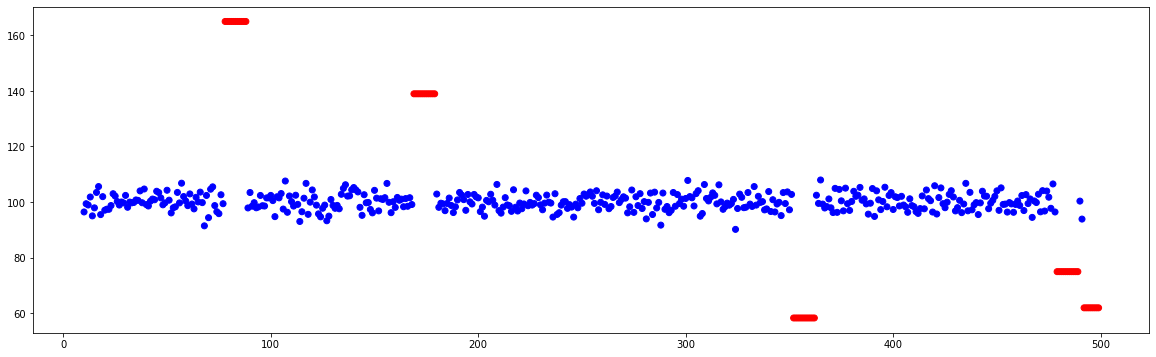

In [11]:
plot(row[0: 500], out_target[0: 500])

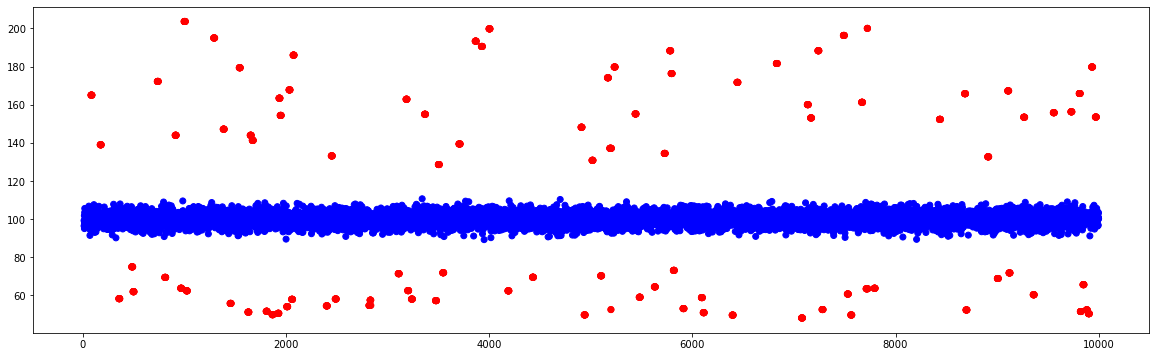

In [12]:
plot(row, out_target)

## Плавное изменение значений (без выбросов)

Синусоида + шум

In [13]:
def gen_sin_row(mean, scale, size=10000, seed=17):
    np.random.seed(17)
    row = np.sin(np.arange(size)/ 300)*5 + np.random.normal(mean, scale, size)
    out_target = np.array([False]*size)
    return row, out_target

In [14]:
row, out_target = gen_sin_row(100, 1)

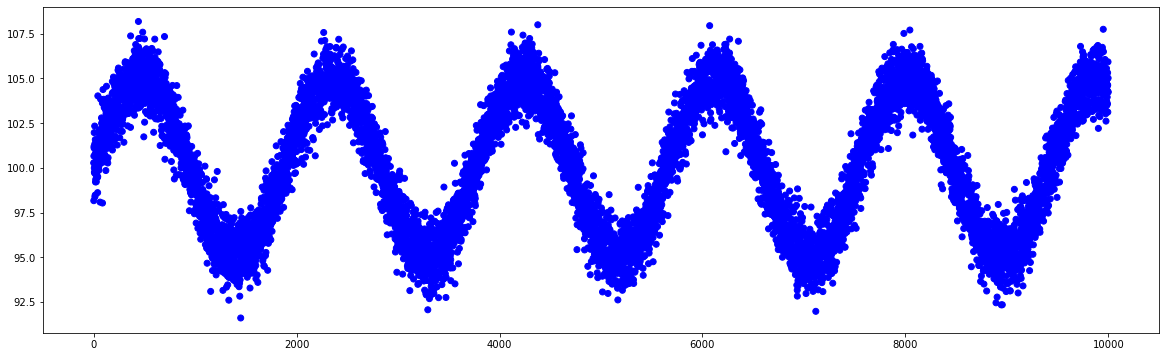

In [15]:
plot(row, out_target)

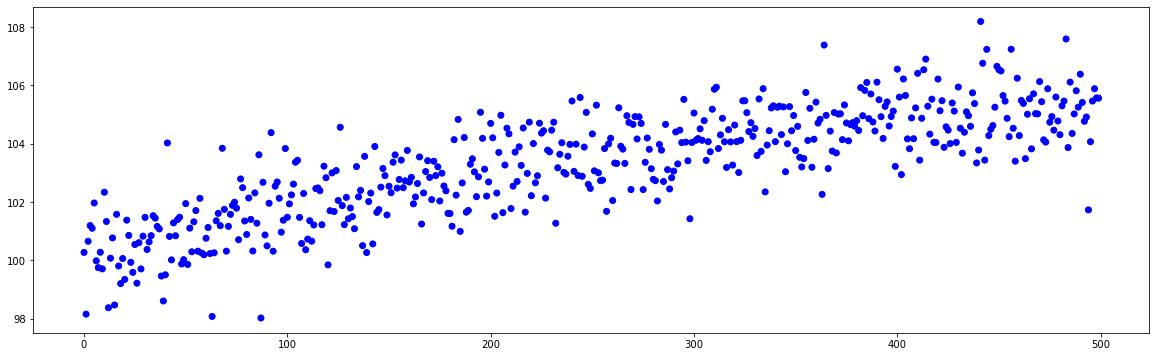

In [16]:
plot(row[:500], out_target[:500])

## Изменение значений ступенями с резким скачком

1. Генерируются отдельные отрезки из нормального распределения, с скачкоображным переходом между ними

2. Выбросом счит только первая точка после скачка

In [17]:
def gen_step_change(n_steps=25, scale=5, min_value=0, max_value=500, size=10000, seed=17):
    assert size % n_steps == 0, "Длина ряда должна делиться на количество ступеней без остатка"
    n_points = size // n_steps
    res = []
    out_target = []
    
    mean = None
    for step in range(n_steps):
        while True:
            # Make sure that the gap is exists
            new_mean = np.random.uniform(min_value, max_value)
            if mean is None or abs(new_mean - mean) > 50:
                mean = new_mean
                break
        row = np.random.normal(mean, scale, size=n_points)
        res.append(row)
        if step != 0:
            out_target.append([True] + [False]*(n_points-1))
        else:
            out_target.append([False] * n_points)
            
    row = np.concatenate(res)
    out_target = np.concatenate(out_target)
    return row, out_target

In [18]:
row, out_target = gen_step_change()

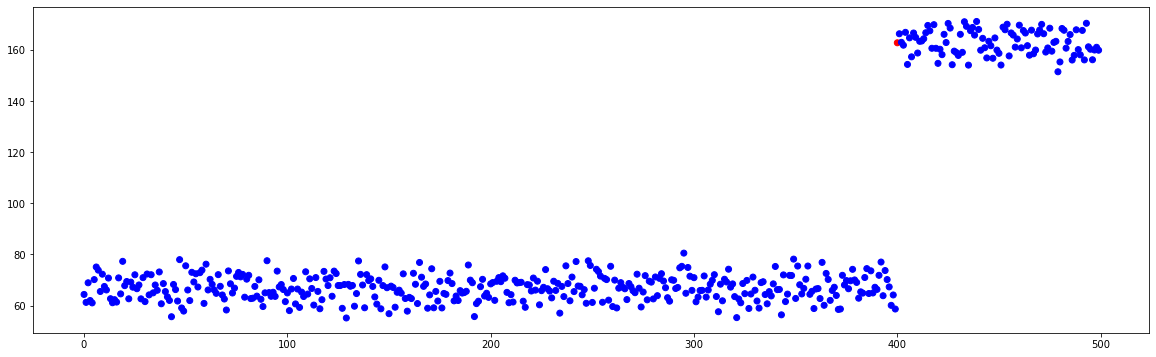

In [19]:
plot(row[:500], out_target[:500])

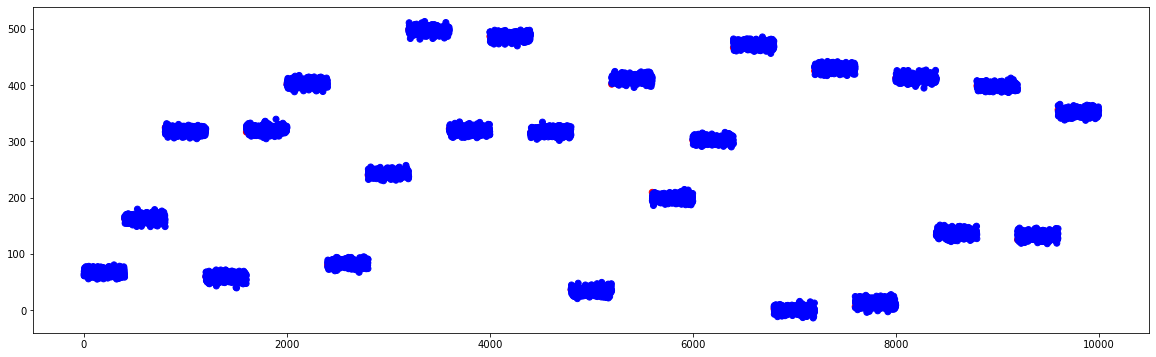

In [20]:
plot(row, out_target)